## Name: Prashil Tumbade

## DSCI6004 FINAL PROJECT

# News Aggregator

## Goal

- ** Primary Goal : To aggregate similar news articles from different multiple news sources and use machine learning algorithm to cluster similar articles.**
- ** Secondary Goal: Topic modelling on news articles. **


## Examples

- Google News
- Flipboard
- Apple's News App
- Feedly

## RSS feeds

In [1]:
## collected bunch of RSS News feeds
feeds = [
    'http://www.sfgate.com/rss/feed/Tech-News-449.php',
    'http://feeds.feedburner.com/TechCrunch/startups',
    'http://news.cnet.com/8300-1001_3-92.xml',
    'http://www.zdnet.com/news/rss.xml',
    'http://www.computerweekly.com/rss/Latest-IT-news.xml',
    'http://feeds.reuters.com/reuters/technologyNews',
    'http://www.tweaktown.com/news-feed/'
    'http://feeds.nytimes.com/nyt/rss/Technology'
]

## Imports

In [2]:
import feedparser
import nltk
import string
import numpy as np
import re
from operator import itemgetter
import operator
from wordcloud import WordCloud
import operator
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

## Parse the feeds into set of words per document

In [3]:
## regular expression to capture html tags in text documents
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    """
    This function removes all the HTML tags from the text
    INPUT: text as string
    OUTPUT: text(string) with all HTML tags removed
    """
    return TAG_RE.sub('', text)

In [4]:
# Creating a corpus of news headlines and their description
corpus = []
titles=[]
content = []
ct = -1
for feed in feeds:
    d = feedparser.parse(feed)
    for e in d['entries']:
        # removes HTML tags from news description
        content.append(remove_tags(e['description']))
        # tokenizing
        words = nltk.wordpunct_tokenize(remove_tags(e['description']))
        words.extend(nltk.wordpunct_tokenize(e['title']))
        # lowering the words
        lowerwords=[x.lower() for x in words if len(x) > 1]
        ct += 1
        print(ct, "TITLE",e['title'])
        # appending tokenized words in corpus
        corpus.append(lowerwords)
        # appending captured news headlines
        titles.append(e['title'])


0 TITLE Dropbox panned for 'diversity' tweet depicting mostly white people
1 TITLE Dozens of Bay Area tech employees vow to never build a Muslim registry
2 TITLE Sources: Google to give Cubans faster access to content
3 TITLE Snapchat: How the vanishing-photo app managed not to fade
4 TITLE Gov't proposal envisions phone calls on airline flights
5 TITLE Apple chief Tim Cook picked to give MIT commencement speech
6 TITLE Navy's futuristic-looking USS Zumwalt arrives in homeport
7 TITLE Banking on change: Tech startups target financial services
8 TITLE Sandberg: False stories on Facebook didn't sway election
9 TITLE Pebble discontinuing smartwatches after its sale to Fitbit
10 TITLE German intel agency: Russia is trying to destabilize Germany
11 TITLE Softbank tycoon who met with Trump is Japan's deal maker
12 TITLE Innovation or monopoly? Panel looks at ATT-Time Warner deal
13 TITLE Millions leap at party invite by Mexican rural family
14 TITLE 6 ways to keep phone charges low during in

## Removal of stopwords

In [5]:
stop = set(stopwords.words('english'))
corpus_new = []
for c in corpus:
    temp = []
    for word in c:
        if word not in stop:
            temp.append(word)
    corpus_new.append(temp)
corpus = corpus_new

In [6]:
# checking the total number of news articles collected 
len(corpus)

125

## Checking counts of frequent word occurence in the corpus 

In [7]:
total_words = []

for c in content:
    total_words.extend(c.split(' '))

In [8]:
word_counts = Counter(total_words)
word_counts_sorted = sorted(word_counts.items(), 
                            key=operator.itemgetter(1),
                            reverse=True)

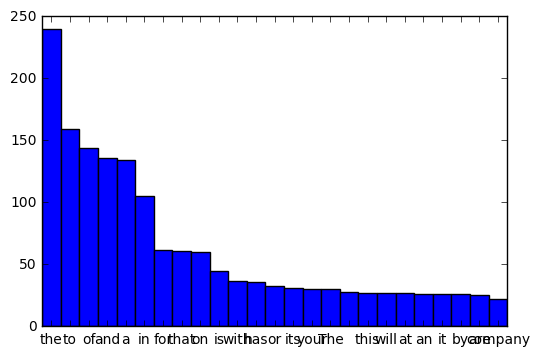

In [9]:
sample = word_counts_sorted[:25]
labels, values = zip(*sample)
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

This confirms the Zipf's Law because the most frequent word occurs as twice as often as the second most frequent word.

## Tf-idf implementation

In [10]:
def freq(word, document):
    return document.count(word)

def wordCount(document): 
    return len(document)

def numDocsContaining(word,documentList):
    count = 0
    for document in documentList:
        if freq(word,document) > 0:
            count += 1
    return count

def tf(word, document):
    return (freq(word,document) / float(wordCount(document)))

def idf(word, documentList): 
    return np.log(len(documentList) / numDocsContaining(word,documentList))

def tfidf(word, document, documentList):
    return (tf(word,document) * idf(word,documentList))


## Extract top keywords from each doc

In [11]:
def top_keywords(n,doc,corpus):
    """
    Returns number of top keywords in each document
    """
    d = {}
    for word in set(doc):
        d[word] = tfidf(word,doc,corpus)
    sorted_d = sorted(d.items(), key=operator.itemgetter(1))
    sorted_d.reverse()
    return [w[0] for w in sorted_d[:n]]   

key_word_list=set()
nkeywords=4

for doc in corpus:
    for x in top_keywords(nkeywords,doc,corpus):
        key_word_list.add(x)

# printing top keywords from each document
for ct, doc in enumerate(corpus):
    print(ct,"KEYWORDS"," ".join(top_keywords(nkeywords,doc,corpus)))


0 KEYWORDS tweet dropbox headlines diversity
1 KEYWORDS never area muslim registry
2 KEYWORDS cubans access google cuban
3 KEYWORDS snapchat share people contrast
4 KEYWORDS calls proposal passengers flight
5 KEYWORDS mit cook chief important
6 KEYWORDS navy zumwalt homeport uss
7 KEYWORDS money industry financial customers
8 KEYWORDS sandberg facebook election executive
9 KEYWORDS pebble fitbit devices bulk
10 KEYWORDS germany election russian russia
11 KEYWORDS softbank computer japan billion
12 KEYWORDS warner deal time ads
13 KEYWORDS party horse ibarra local
14 KEYWORDS offline hotel phone international
15 KEYWORDS 8211 talkbank popov &#
16 KEYWORDS source nlu rasa bots
17 KEYWORDS london curve fintech android
18 KEYWORDS soylent powder sale yet
19 KEYWORDS live stream entertainment living
20 KEYWORDS mccarty eaze ceo startup
21 KEYWORDS plug play summit winter
22 KEYWORDS video attached &# fake
23 KEYWORDS mkrzero arduino small 8217
24 KEYWORDS ipad clip equations explaineverythi

## turn each doc into a feature vector using TF-IDF score

In [13]:
feature_vectors=[]
n=len(corpus)

for document in corpus:
    vec=[]
    for word in key_word_list:
        if word in document:
            vec.append(tfidf(word,document,corpus))
        else:
            vec.append(0)
    feature_vectors.append(vec)


## matrix of Cosine similarities

In [14]:
mat = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        mat[i][j] = nltk.cluster.util.cosine_distance(feature_vectors[i],feature_vectors[j])


In [15]:
## shows how much ith document is similar to jth document
print(mat[2][1])
print(mat[3][2])
print(mat[1][2])

0.99046316026
0.916524396984
0.99046316026


## Now hierarchically cluster the cosine matrix

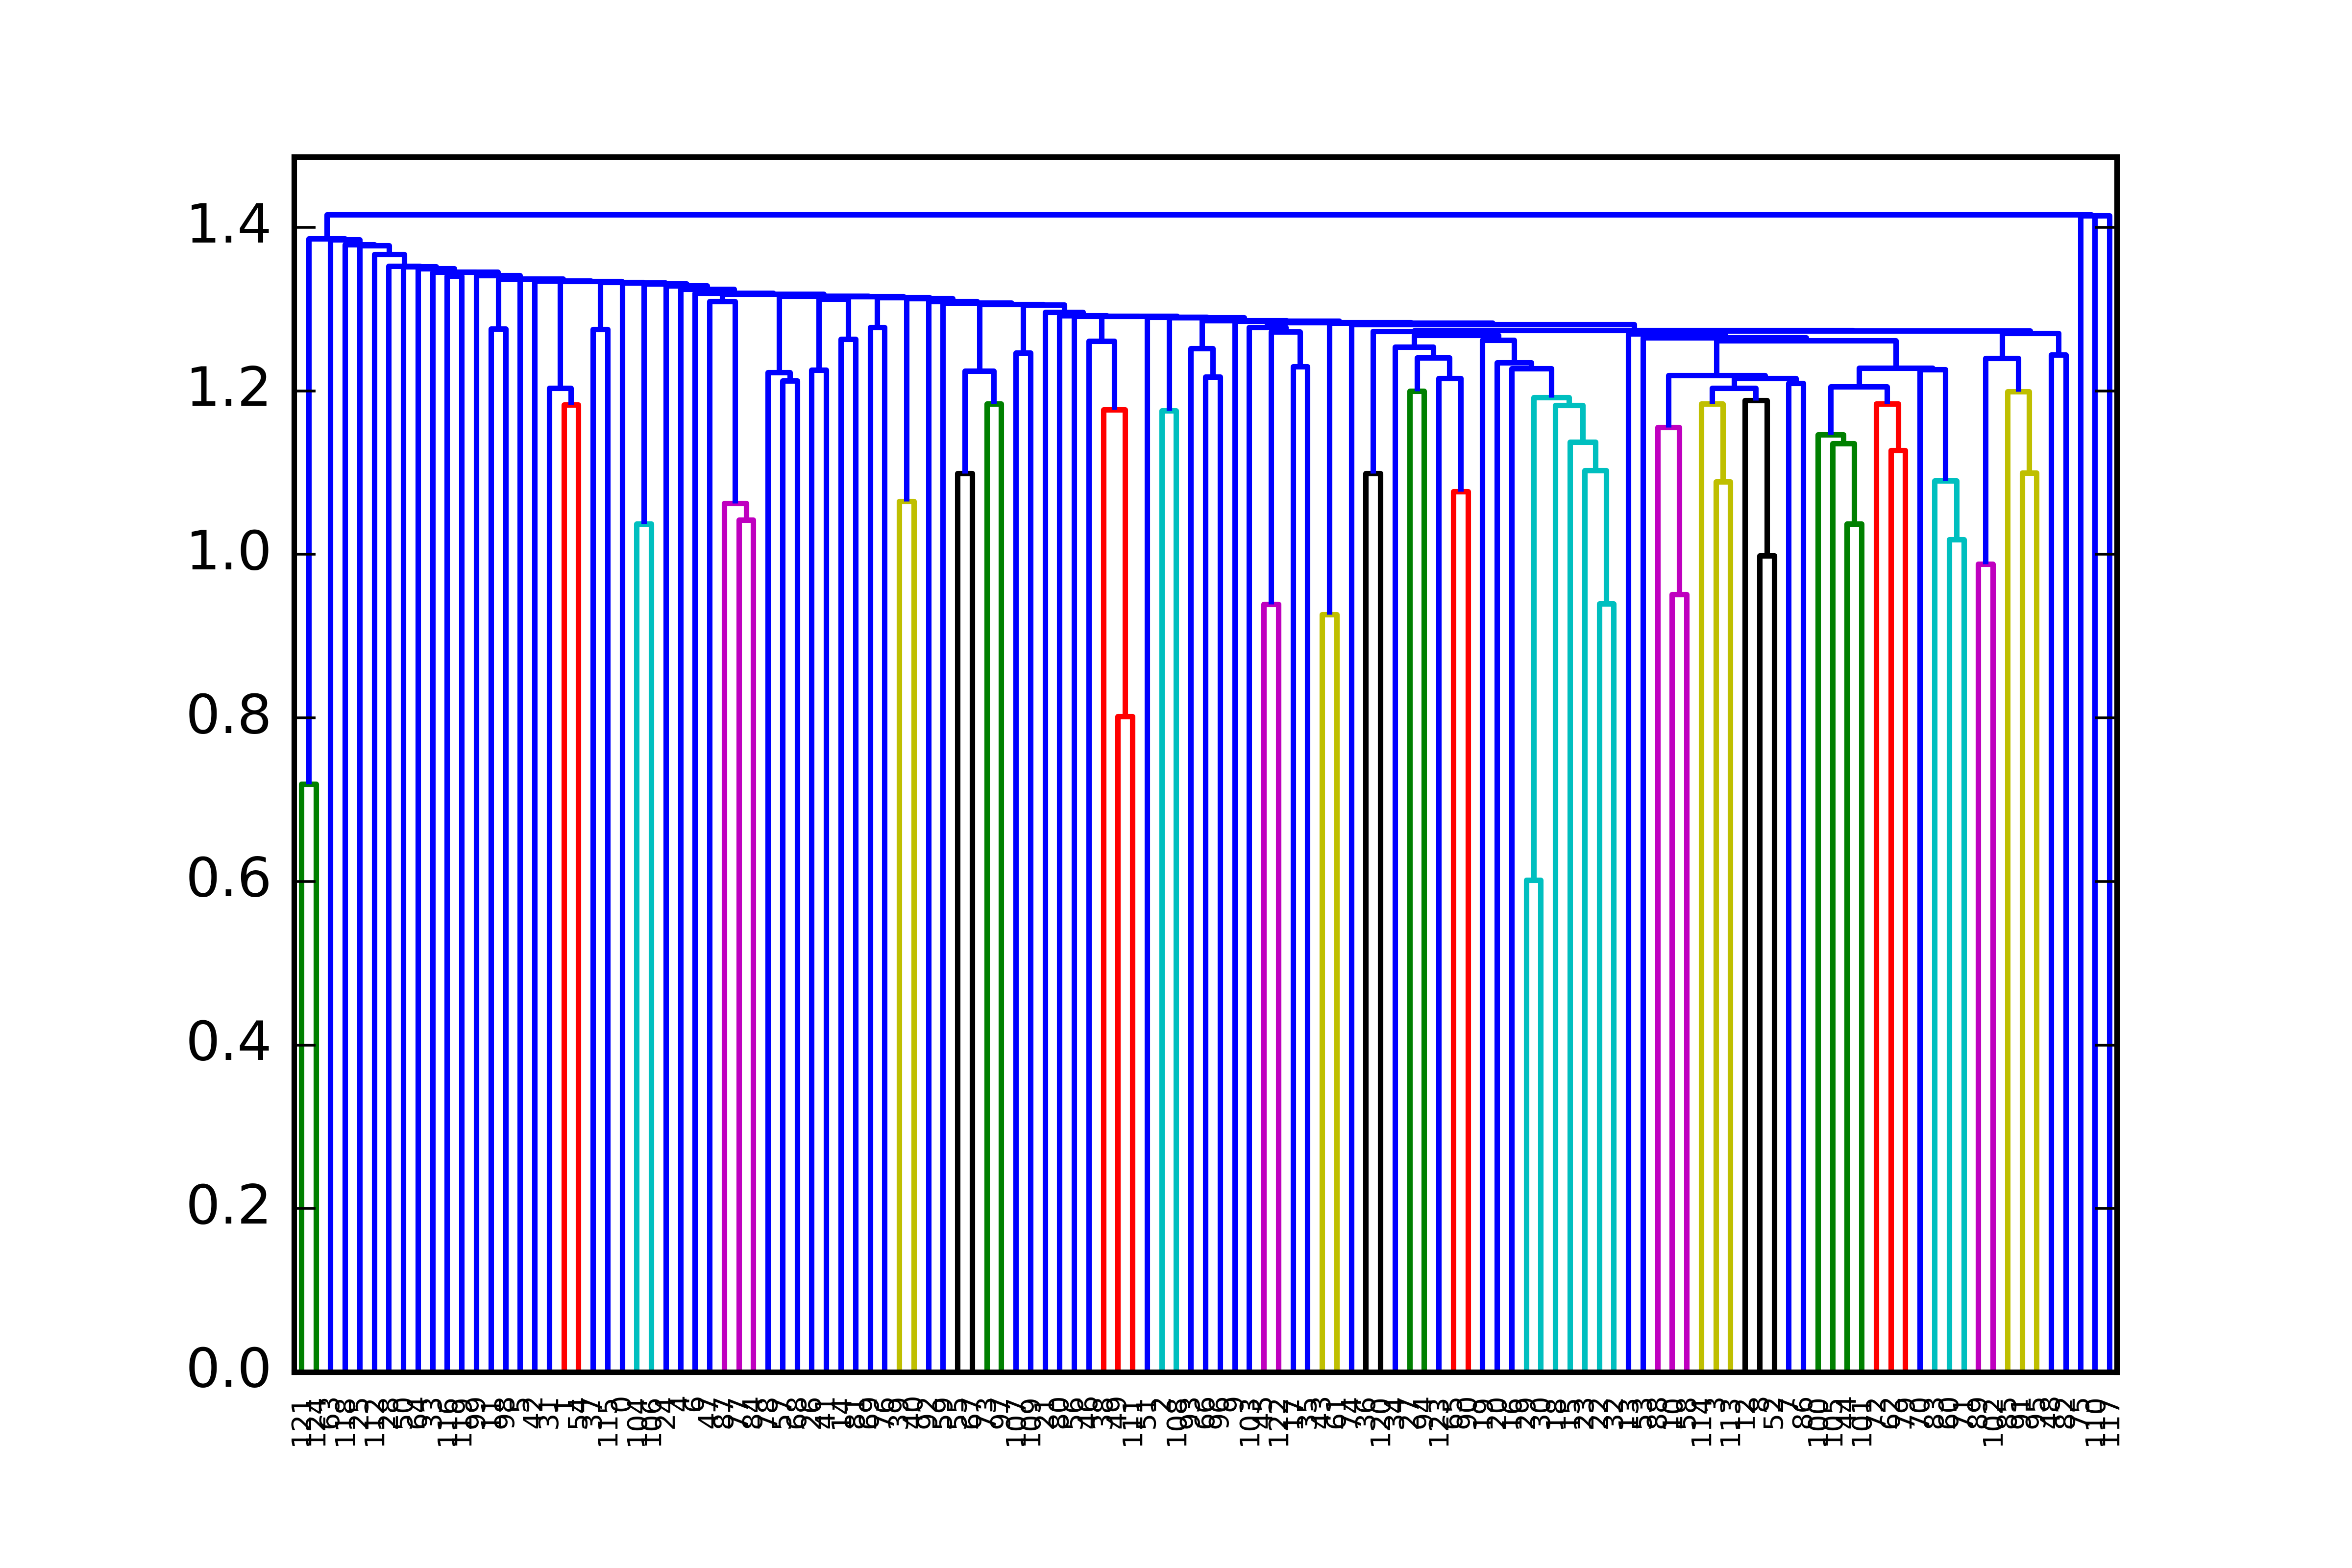

In [16]:
# used hierarchical clustering because feeds are in real time and continously varying 
# so KMeans is not a good option to use here for clustering
# since you cannot decide the value of K (number of clusters) with real time continuous data

from scipy.cluster.hierarchy import linkage, dendrogram
t = 1.2
Z = linkage(mat, 'single')
dendrogram(Z, color_threshold=t)

# saving dendrogram results to Image file
import pylab
pylab.savefig( "hcluster.png" ,dpi=800)

# displaying the dendrogram results
from IPython.display import Image
Image(filename='hcluster.png') 

## Extract our clusters

In [17]:
def extract_clusters(Z,threshold,n):
    """
    Returns the clusters with title IDs
    """
    clusters={}
    ct=n
    for row in Z:
        if row[2] < threshold:
            n1=int(row[0])
            n2=int(row[1])

            if n1 >= n:
                l1=clusters[n1] 
                del(clusters[n1]) 
            else:
                 l1= [n1]

            if n2 >= n:
                l2=clusters[n2] 
                del(clusters[n2]) 
            else:
                l2= [n2]    

            l1.extend(l2)  
            clusters[ct] = l1
            ct += 1
        else:
            return clusters

clusters = extract_clusters(Z,t,n)

## printing titles of the clustered news articles
for key in clusters:
    print("=============================================")
    for id in clusters[key]:
        print(id,titles[id])

43 Weekend streaming: Amazon's originals return     - CNET
61 Inside Amazon's clickworker platform: How half a million people are being paid pennies to train AI
45 Knockoff Super Mario Run apps hit Google Play     - CNET
122 Super Mario Run to make $60 million in first month
89 Yahoo hacked: One billion users affected by August 2013 data breach, company confirms
102 Yahoo under scrutiny after latest hack, Verizon seeks new deal terms
104 Uber says disappointed by Taiwan law raising ride-sharing fine to highest level globally
106 French government tells Uber to talk to protesting drivers
87 BMW Group uses IBM Watson to explore personalised driver systems
77 ​Australia's NCI gets supercomputing systems from IBM for AI and analytics
84 Smart machines primed to accelerate across business
39 'DuckTales' reboot to feature 'Doctor Who,' 'SNL' stars     - CNET
40 Hollywood stars' video begs Electoral College to snub Trump     - CNET
65 Microsoft outlines plans to build a 'world graph' for geog

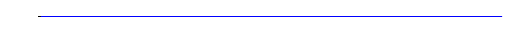

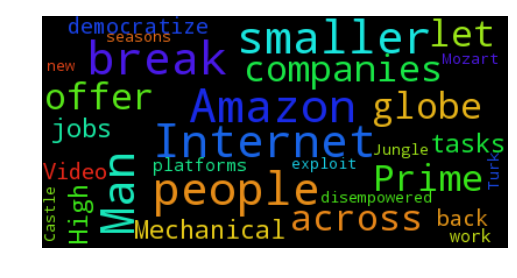

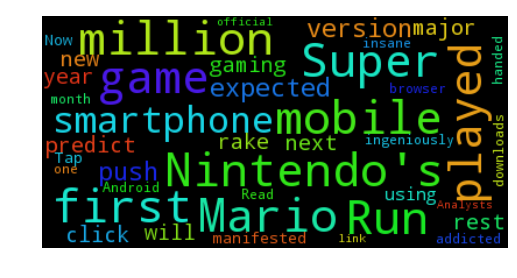

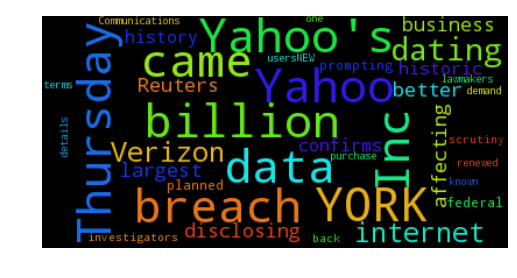

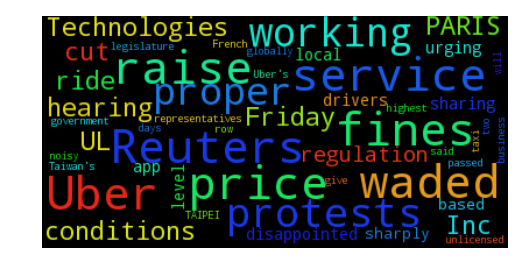

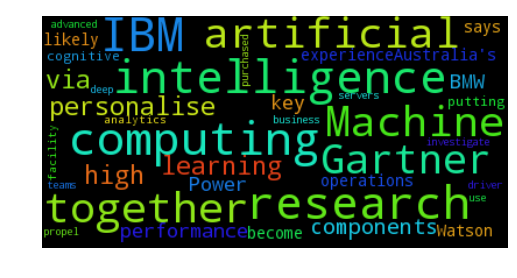

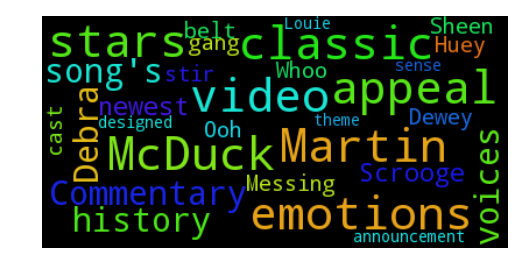

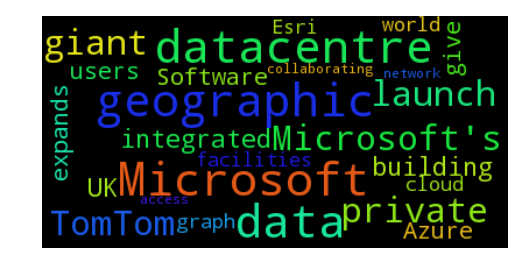

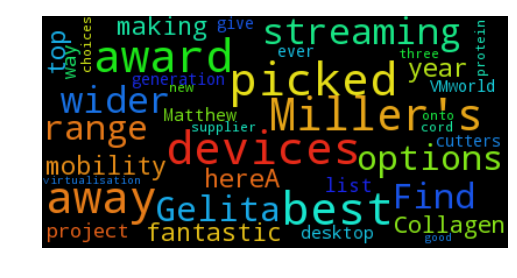

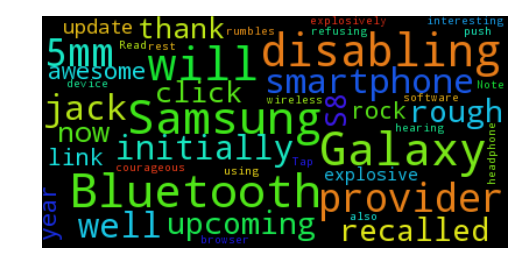

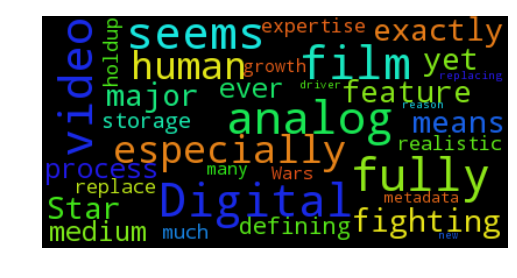

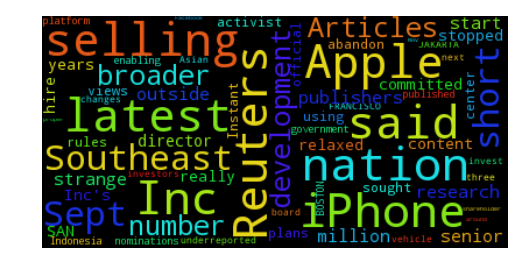

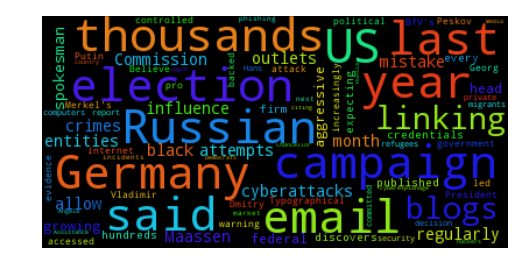

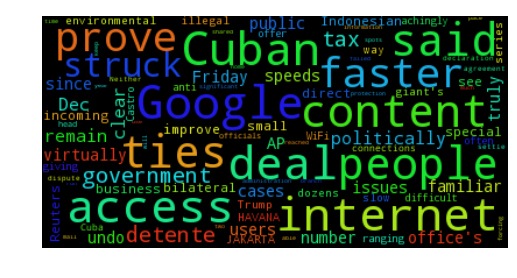

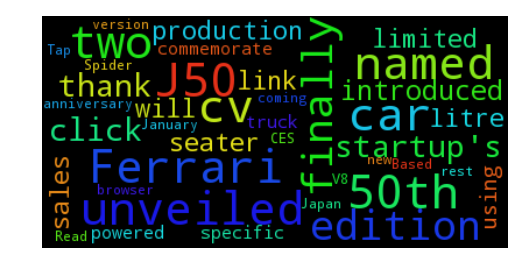

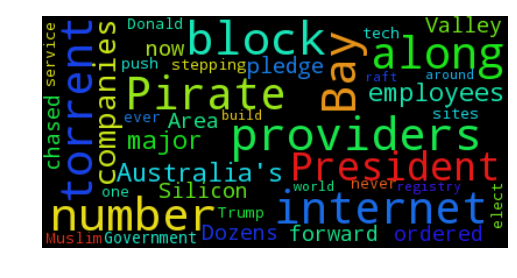

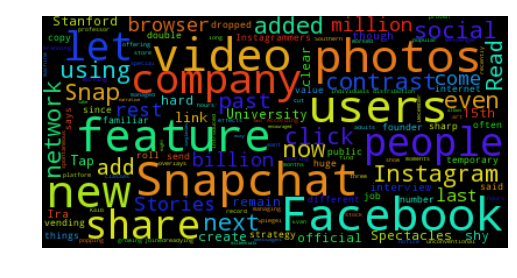

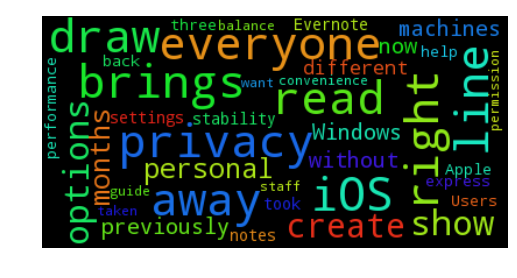

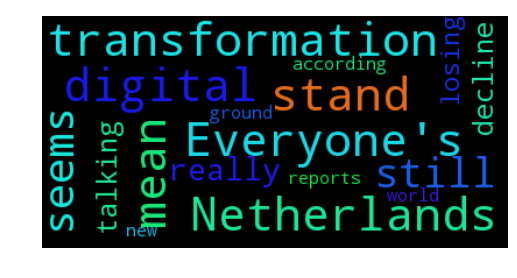

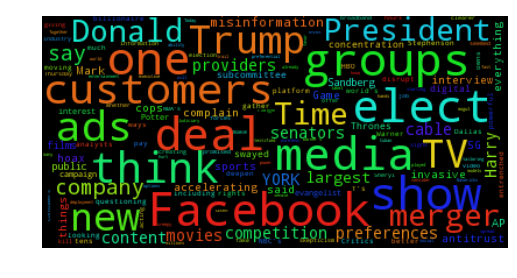

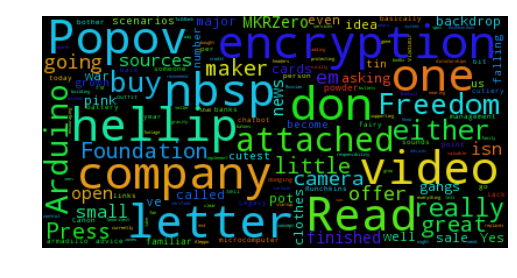

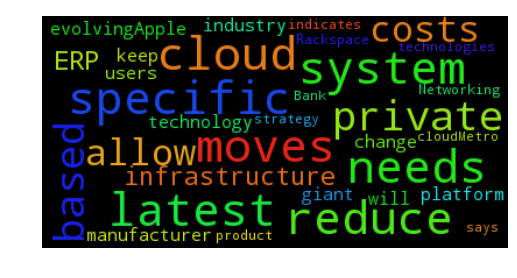

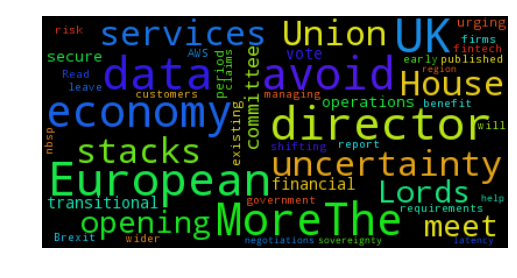

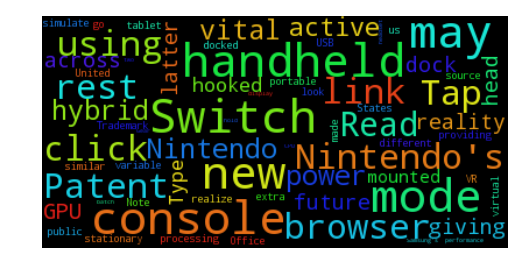

In [20]:
# Generate a word cloud image of all the clustered news article to see relevance of the aggreagted news articles

clustered_content = []

for key in clusters:
    c = ""
    for id in clusters[key]:
        c += content[id]
    clustered_content.append(c) 
    
for c in clustered_content:
    wordcloud = WordCloud(max_font_size=40).generate(c)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()